In [1]:
# Not working
from ocpy.ocp import OCP
from ocpy.ddp import DDPSolver
from ocpy.mpc import MPC
import numpy as np

ocp = OCP.SampleOCPCartpole()
# reset parameters
t0 = 0.0
T = 2.0
N = 100
x0 = np.zeros(4)
us_guess = np.zeros((N, 1))

ocp.reset_parameters(t0, T, N, x0, us_guess)
ddp = DDPSolver(ocp)

mpc = MPC(ddp)


In [2]:
t_start = 0.0
T_sim = 10
sampling_time = 0.020
mpc.init_mpc(t_start, damp_init=0.0, damp_min=0.0, damp_max=0.0)



(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
        1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
        1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
        1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
        1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
        1.98, 2.  ]),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, -3.74828392e-02,
          7.49656784e-02],
        [-7.49656784e-04,  1.49931357e-03, -7.69227464e-02,
          1.53845493e-01],
        [-2.28811171e-03,  4.57622342e-03, -1.17895

In [3]:
mpc.run(T_sim, sampling_time, max_iter=1)

time:  0.0
time:  0.02
time:  0.04
time:  0.06
time:  0.08
time:  0.1
time:  0.12
time:  0.14
time:  0.16
time:  0.18
time:  0.2
time:  0.22
time:  0.24
time:  0.26
time:  0.28
time:  0.3
time:  0.32
time:  0.34
time:  0.36
time:  0.38
time:  0.4
time:  0.42
time:  0.44
time:  0.46
time:  0.48
time:  0.5
time:  0.52
time:  0.54
time:  0.56
time:  0.58
time:  0.6
time:  0.62
time:  0.64
time:  0.66
time:  0.68
time:  0.7000000000000001
time:  0.72
time:  0.74
time:  0.76
time:  0.78
time:  0.8
time:  0.8200000000000001
time:  0.84
time:  0.86
time:  0.88
time:  0.9
time:  0.92
time:  0.9400000000000001
time:  0.96
time:  0.98
time:  1.0
time:  1.02
time:  1.04
time:  1.06
time:  1.08
time:  1.1
time:  1.12
time:  1.1400000000000001
time:  1.16
time:  1.18
time:  1.2
time:  1.22
time:  1.24
time:  1.26
time:  1.28
time:  1.3
time:  1.32
time:  1.34
time:  1.36
time:  1.3800000000000001
time:  1.4000000000000001
time:  1.42
time:  1.44
time:  1.46
time:  1.48
time:  1.5
time:  1.52
time: 

<lambdifygenerated-22>:4: RuntimeWarning: overflow encountered in double_scalars
  return 0.0002*Dummy_164**2 + 0.0002*Dummy_165**2 + 0.05*Dummy_167**2 + 0.02*Dummy_168**2 + 1.97392088021787*(0.318309886183791*Dummy_166 - 1)**2
<lambdifygenerated-16>:6: RuntimeWarning: overflow encountered in double_scalars
  [0.02*_Dummy_123 + _Dummy_125, 0.02*_Dummy_122 + _Dummy_124, _Dummy_123 + 0.02*(_Dummy_126 + 0.1*(0.5*_Dummy_124**2 + 9.80665*cos(_Dummy_124))*sin(_Dummy_124))/(0.1*sin(_Dummy_124)**2 + 2), _Dummy_122 + 0.04*(-0.05*_Dummy_124**2*sin(_Dummy_124)*cos(_Dummy_124) - _Dummy_126*cos(_Dummy_124) - 20.593965*sin(_Dummy_124))/(0.1*sin(_Dummy_124)**2 + 2)])
/home/ohtsukalab/src/ocpy/ocpy/ddp.py:275: RuntimeWarning: invalid value encountered in matmul
  us_new[i] += alpha * ks[i] + Ks[i] @ (xs_new[i] - xs[i])
<lambdifygenerated-16>:6: RuntimeWarning: invalid value encountered in cos
  [0.02*_Dummy_123 + _Dummy_125, 0.02*_Dummy_122 + _Dummy_124, _Dummy_123 + 0.02*(_Dummy_126 + 0.1*(0.5*_Dummy

time:  1.84
time:  1.86
time:  1.8800000000000001
time:  1.9000000000000001
time:  1.92
time:  1.94
time:  1.96
time:  1.98
time:  2.0
time:  2.02
time:  2.04
time:  2.06
time:  2.08
time:  2.1
time:  2.12
time:  2.14
time:  2.16
time:  2.18
time:  2.2
time:  2.22
time:  2.24
time:  2.2600000000000002
time:  2.2800000000000002
time:  2.3000000000000003
time:  2.32
time:  2.34
time:  2.36
time:  2.38
time:  2.4
time:  2.42


<lambdifygenerated-16>:6: RuntimeWarning: invalid value encountered in double_scalars
  [0.02*_Dummy_123 + _Dummy_125, 0.02*_Dummy_122 + _Dummy_124, _Dummy_123 + 0.02*(_Dummy_126 + 0.1*(0.5*_Dummy_124**2 + 9.80665*cos(_Dummy_124))*sin(_Dummy_124))/(0.1*sin(_Dummy_124)**2 + 2), _Dummy_122 + 0.04*(-0.05*_Dummy_124**2*sin(_Dummy_124)*cos(_Dummy_124) - _Dummy_126*cos(_Dummy_124) - 20.593965*sin(_Dummy_124))/(0.1*sin(_Dummy_124)**2 + 2)])


time:  2.44
time:  2.46
time:  2.48
time:  2.5
time:  2.52
time:  2.54
time:  2.56
time:  2.58
time:  2.6
time:  2.62
time:  2.64
time:  2.66
time:  2.68
time:  2.7
time:  2.72
time:  2.74
time:  2.7600000000000002
time:  2.7800000000000002
time:  2.8000000000000003
time:  2.82
time:  2.84
time:  2.86
time:  2.88
time:  2.9
time:  2.92
time:  2.94
time:  2.96
time:  2.98
time:  3.0
time:  3.02
time:  3.04
time:  3.06
time:  3.08
time:  3.1
time:  3.12
time:  3.14
time:  3.16
time:  3.18
time:  3.2
time:  3.22
time:  3.24
time:  3.2600000000000002
time:  3.2800000000000002
time:  3.3000000000000003
time:  3.3200000000000003
time:  3.34
time:  3.36
time:  3.38
time:  3.4
time:  3.42
time:  3.44


<lambdifygenerated-28>:3: RuntimeWarning: overflow encountered in double_scalars
  return 0.01*Dummy_206**2 + 0.01*Dummy_207**2 + 2.5*Dummy_209**2 + 98.6960440108936*(0.318309886183791*Dummy_208 - 1)**2


time:  3.46
time:  3.48
time:  3.5
time:  3.52
time:  3.54
time:  3.56
time:  3.58
time:  3.6
time:  3.62
time:  3.64
time:  3.66
time:  3.68
time:  3.7
time:  3.72
time:  3.74
time:  3.7600000000000002
time:  3.7800000000000002
time:  3.8000000000000003
time:  3.8200000000000003
time:  3.84
time:  3.86
time:  3.88
time:  3.9
time:  3.92
time:  3.94
time:  3.96
time:  3.98
time:  4.0
time:  4.0200000000000005
time:  4.04
time:  4.0600000000000005
time:  4.08
time:  4.1
time:  4.12
time:  4.14
time:  4.16
time:  4.18
time:  4.2
time:  4.22
time:  4.24
time:  4.26
time:  4.28
time:  4.3
time:  4.32
time:  4.34
time:  4.36
time:  4.38
time:  4.4
time:  4.42
time:  4.44
time:  4.46
time:  4.48
time:  4.5
time:  4.5200000000000005
time:  4.54
time:  4.5600000000000005
time:  4.58
time:  4.6000000000000005
time:  4.62
time:  4.64
time:  4.66
time:  4.68
time:  4.7
time:  4.72
time:  4.74
time:  4.76
time:  4.78
time:  4.8
time:  4.82
time:  4.84
time:  4.86
time:  4.88
time:  4.9
time:  4.92

(array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ,  1.02,  1.04,  1.06,
         1.08,  1.1 ,  1.12,  1.14,  1.16,  1.18,  1.2 ,  1.22,  1.24,
         1.26,  1.28,  1.3 ,  1.32,  1.34,  1.36,  1.38,  1.4 ,  1.42,
         1.44,  1.46,  1.48,  1.5 ,  1.52,  1.54,  1.56,  1.58,  1.6 ,
         1.62,  1.64,  1.66,  1.68,  1.7 ,  1.72,  1.74,  1.76,  1.78,
         1.8 ,  1.82,  1.84,  1.86,  1.88,  1.9 ,  1.92,  1.94,  1.96,
         1.98,  2.  ,  2.02,  2.04,  2.06,  2.08,  2.1 ,  2.12,  2.14,
         2.16,  2.18,  2.2 ,  2.22,  2.24,  2.26,  2.28,  2.3 ,  2.32,
         2.34,  2.36,  2.38,  2.4 ,  2.42,  2.44,  2.46,  2.48,  2.5 ,
      

/home/ohtsukalab/src/ocpy/ocpy/plotter.py:136: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i][j].set_yscale('log')
/home/ohtsukalab/src/ocpy/ocpy/plotter.py:137: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  axes[i][j].set_xlim(0, iter-1)


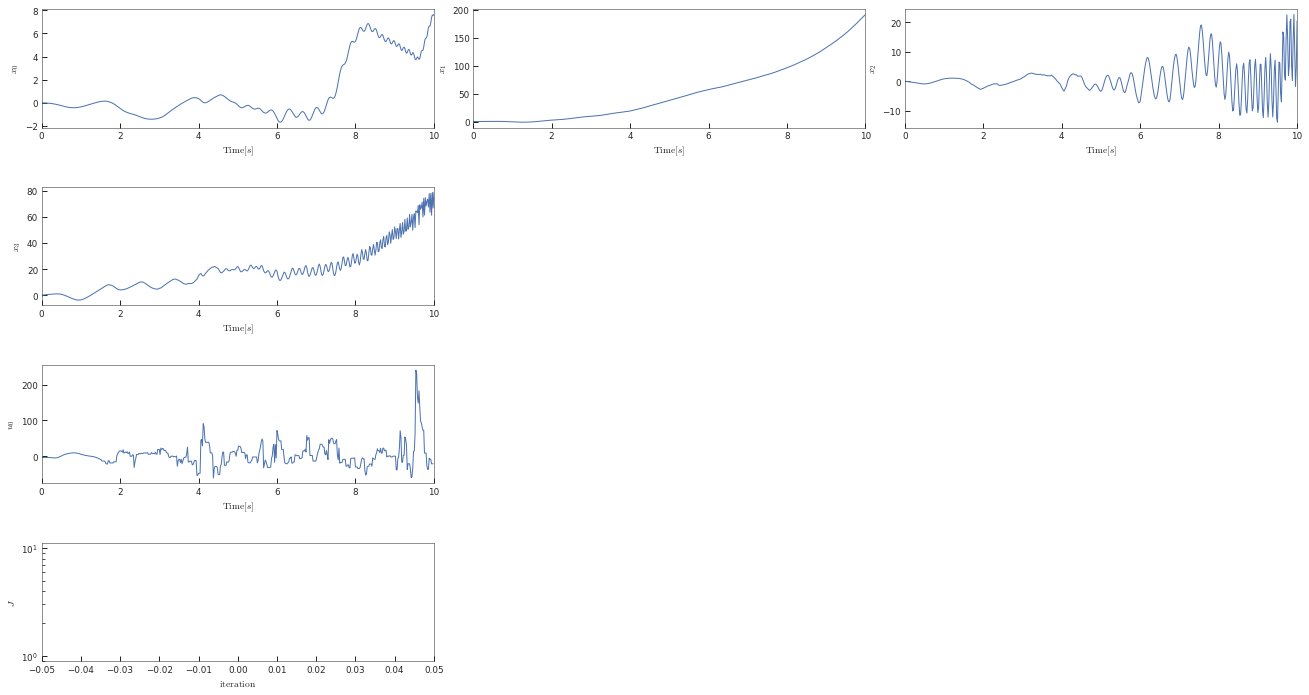

In [4]:
mpc.plot()

In [5]:
ddp._x0

array([0., 0., 0., 0.])

In [6]:
np.array(arr)

NameError: name 'arr' is not defined

In [ ]:
f = ocp.get_derivatives()[0][0]
f(x0, [1], 0)

array([ 0.  ,  0.  ,  0.01, -0.02])